# Practical 2

# Task 1: The Data

We use the mouse protein expression dataset: https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression
Please use the code provided below for loading the dataset.
Let's start with a bit of exploration.

### Tasks 1.1: Dataset Exploration 
- How many samples / features are provided?
- How many labels does the dataset have?
- What is the value range of the individuals predictors?
- Visualize the 10 first samples of the dataset in a form that highlights their differences.
- Visualize the variance of each predictor.


In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')
% cd gdrive/MyDrive/ml_2021

/content/gdrive/MyDrive/ml_2021


In [1]:
import plotly as ply
import plotly.express as px
import plotly.graph_objects as go
from copy import deepcopy

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

file = 'data/Data_Cortex_Nuclear.csv'
df = pd.read_csv(file)

N = 10  # use only every tenth sample
X_all = df.iloc[::N,1:65].to_numpy()
t_all = (df['Behavior'] == 'S/C').to_numpy()[::N]

idx = ~np.any(np.isnan(X_all), axis=1)
X_all = X_all[idx]
t_all = t_all[idx]

In [5]:
#Include normalize (by range) function for plotting later
def normalize(data):
  cols = data.shape[1]

  #normdat = data
  normdat = deepcopy(data)

  for k in range(cols):
    mu = np.mean(normdat[:,k])
    max = np.max(normdat[:,k])
    min = np.min(normdat[:,k])

    normdat[:,k] = (normdat[:,k] - mu) / (max-min)
  
  return normdat

Find out answers to questions above:

In [6]:
#how many samples/features:
print("We've got", X_all.shape[0], "samples and", X_all.shape[1], "features.")

We've got 105 samples and 64 features.


In [7]:
#the classes/labels are in the 'class' variable
print("We've got", len(np.unique(t_all)), "different labels.")

We've got 2 different labels.


In [8]:
#print class labels
np.unique(df['Behavior'])

array(['C/S', 'S/C'], dtype=object)

In [9]:
###ranges of numeric predictors

maxvals = np.max(X_all, axis = 0)
minvals = np.min(X_all, axis = 0)

const_dict = {'min': minvals, 'max': maxvals}
range_df = pd.DataFrame(const_dict)

#display range of first few predictors
range_df.head()

,min,max
0,0.168493,2.480316
1,0.292269,2.488684
2,0.198159,0.446958
3,1.564858,3.174743
4,1.991141,6.465180


In [10]:
##visualising first nine observations as this allows for a 3*3 grid
##and that just looks a lot nicer


normdat = normalize(X_all)

pred_names = ['pred'+str(i) for i in range(X_all.shape[1])]

#make plot
fig = ply.subplots.make_subplots(3, 3, specs=[[{'type': 'polar'}]*3]*3, 
                                 horizontal_spacing = 0.2,
                                 vertical_spacing = 0.05, 
                                 subplot_titles = ['obs'+str(i+1) for i in range(9)]
                                 )

for x in range(3):
  for y in range(3):
    k = x * 3 + y


    const_dict = {'theta': pred_names, 'r': normdat[k]}
    plot_df = pd.DataFrame(const_dict)

    fig.add_trace(go.Scatterpolar(
        r = plot_df['r'],
        theta = plot_df['theta'],
        mode = 'lines'
    ), row = y+1, col = x+1)
  
fig.update_layout(height=900, width=900, showlegend = False)
fig.show()

In [11]:
#variances = pd.DataFrame.var(df[num_preds], axis = 0)

variances = np.var(X_all, axis = 0)

const_dict = {'var': variances, 'names': pred_names}
plot_df = pd.DataFrame(const_dict)


fig = px.line_polar(plot_df, r='var', theta='names', line_close=True)
fig.update_layout(height=900, width=900, showlegend = False, title = "Variance of all predictors")
fig.show()

**Task 1.2: Data Preprocessing**:  
- Write a function `split_data(X, y, frac, seed)` that first shuffles your training data and then splits it into a training and a test set. `frac` determines the relative size of the test dataset, `seed` makes sure we get reproducible 
results.  
- Write a function `preprocess(X)` which zero-centers your data and sets variance to one (per-feature).

In [12]:
def split_data(X, y, frac=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)

    ### implement the function here
    shuffle_ids = np.array(range(len(y)))
    np.random.shuffle(shuffle_ids)

    slice_ind = int((1-frac) * len(y))

    X = pd.DataFrame(X)

    X = pd.DataFrame.reset_index((X.loc[shuffle_ids,:]), 
                                 drop = True)
    y = y[shuffle_ids]

    X_train = X.loc[:slice_ind-1,]
    y_train = y[:slice_ind]

    X_test = X.loc[slice_ind:,]
    y_test = y[slice_ind:]


    return np.array(X_train), np.array(X_test), y_train, y_test

In [14]:
def preprocess(X):

  normdat = deepcopy(X)

  for k in range(X.shape[1]):
    mu = np.mean(normdat[k])
    std = np.std(normdat[k])

    normdat[k] = (normdat[k] - mu) / std
  
  return normdat

# Task 2: LDA

First, use Linear Discriminant Analysis to separate the classes. As discussed in the Bishop in pg. 186-189, we can find a weight vector $\vec{w}$ that performs a projection of the i-th input data point $\vec{x}_i$

$p =   \vec{w}^T \vec{x}_i$

that optimally separates the classes.

Use the analytic solution to compute the optimal weights $\vec{w}$ from the training set data. 

** Task 2.1 ***

1. Implement a function `compute_lda_weights(x, y)` manually, which carries out LDA using the data `x,y`. 
2. Apply this function on your training data.
3. Visualize the obtained weight vector $\vec{w}$ using a `plt.stemplot`.

In [15]:
def compute_lda_weights(x, y):

  #split x into two groupd
  X1 = x[y,]
  X2 = x[~y,]

  #get group means
  m1 = np.mean(X1, axis = 0)
  m2 = np.mean(X2, axis = 0)

  #get S values
  tmp = X1 - np.resize(m1, (X1.shape[0], X1.shape[1]))
  S1 = np.trace(np.matmul(tmp, tmp.T))

  tmp = X2 - np.resize(m2, (X2.shape[0], X2.shape[1]))
  S2 = np.trace(np.matmul(tmp, tmp.T))

  SWm1 = 1/(S1+S2)

  weights = SWm1 * (m2-m1)

  return m1, m2, (m2-m1), weights

Text(0.5, 0, 'predictors')

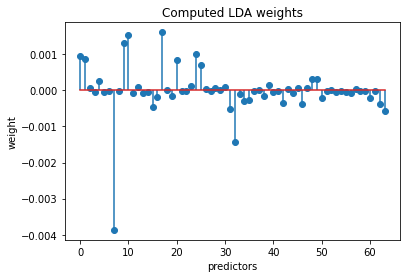

In [16]:
X, X_test, t, t_test = split_data(X_all, t_all, seed=1)
m0, m1, mdiff, w_lda = compute_lda_weights(X, t)

plt.stem(w_lda.flatten(), use_line_collection=True)
plt.title('Computed LDA weights')
plt.ylabel('weight')
plt.xlabel('predictors')

### Task 2.3

Project the training data and the test data on $\vec{w}$. Visualize the class separation using a two-color histogram. 
- Is the class separation good?
- Is there a big difference between training and test data?

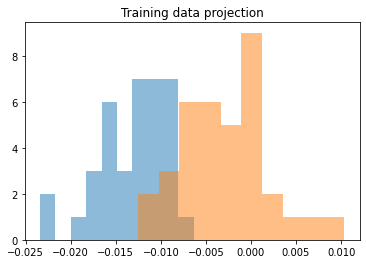

In [17]:
a, b = np.matmul(X[t], w_lda), np.matmul(X[~t], w_lda)  # example data

plt.title('Training data projection')
_ = plt.hist(a,label='class 0',alpha=0.5)
_ = plt.hist(b,label='class 1',alpha=0.5)

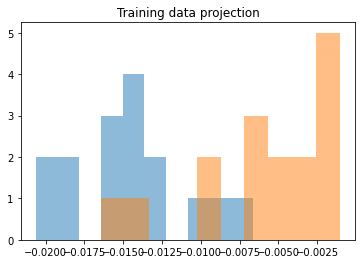

In [18]:
a, b = np.matmul(X_test[t_test], w_lda), np.matmul(X_test[~t_test], w_lda)  # example data

plt.title('Training data projection')
_ = plt.hist(a,label='class 0',alpha=0.5)
_ = plt.hist(b,label='class 1',alpha=0.5)

### Task 2.4 

Now we make class predictions based on the projections. Read https://en.wikipedia.org/wiki/Linear_discriminant_analysis#Fisher's_linear_discriminant and compute threshold $c$ for the projected values $p$ based on the training data. Print the value of $c$ and plot $c$ into the histograms of projected values you made before!

Use $c$ to assign class labels for training and test set. Determine the classification errors (in terms of accuracy) on both datasets and print them. 

In [20]:
c = np.matmul(w_lda.T, (0.5 * (m0+m1)))

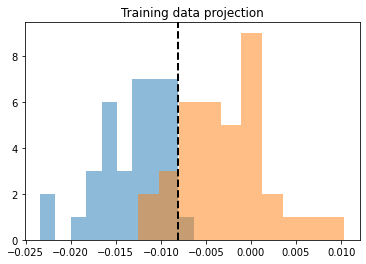

In [21]:
a, b = np.matmul(X[t], w_lda), np.matmul(X[~t], w_lda)  # example data

plt.title('Training data projection')
_ = plt.hist(a,label='class 0',alpha=0.5)
_ = plt.hist(b,label='class 1',alpha=0.5)
_ = plt.axvline(x=c, color = "black", linestyle='dashed', linewidth=2)

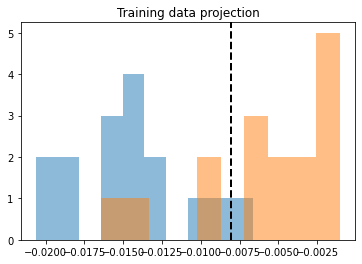

In [22]:
a, b = np.matmul(X_test[t_test], w_lda), np.matmul(X_test[~t_test], w_lda)  # example data

plt.title('Training data projection')
_ = plt.hist(a,label='class 0',alpha=0.5)
_ = plt.hist(b,label='class 1',alpha=0.5)
_ = plt.axvline(x=c, color = "black", linestyle='dashed', linewidth=2)

## Task 3: Logistic Regression

Next, we will consider classification using Logistic Regression. 

For this task, we will use a different dataset:  
It consists of activations from a convolutional neural network (ResNet18) for images of cats and dogs.
The dataset contains 2,000 samples (i.e. CNN activations) and 256 features (i.e. the CNN activations have 256 dimensions). A target value of 0 indicates a cat, 1 a dog.

Below, you find all imports that are necessary.


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import pickle

X_all, t_all = pickle.load(open('data/cnn_features.pickle', 'rb'))

**Task 3.0: Normalize the data**

Make sure the data has has zero mean and variance 1 per feature.

**Task 3.1: Iterative Reweighted Least Squares**

1. Implement the IRLS algorithm and output at each iteration the current training accuracy. Remember the weight are updated according to:
$$ w' = w - ( \Phi^T R \Phi ) ^ {-1} \Phi^T (y - t)$$
Where $y$ is the prediction, $t$ the ground truth target, $R$ the weighting matrix and $\Phi$ the design matrix.  
Hints:  
(a) There is a bias term in logistic regression  
(b) Use a small value for weight init to avoid numerical problems.

2. Apply the IRLS algorithm on data and compute the test accuracy.
3. Compare the results of your implementation to the sklearn implementation of `LogisticRegression(penalty='none')`. Do you get the same result?

**Task 3.2: Logistic Regression with Regularization**

1. Set sklearn's penalty parameter to `l1` and `l2`. Use the range `np.linspace(0.02, 1, 25)` for the parameter `C`, which controls the strength of regularization. Where is the regularization strongest, for small or big `C`?   
Hint: For `l1` regularization you can use the `saga` solver.
2. Plot strength of regularization over accuracy. Does regularization improve the scores?
3. Visualize the coefficients (or just a subset of all coefficient for a better overview) of the regularized settings and the unregularized setting. What do you observe?
3. Compare the coefficients to the LDA weights.

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
# regplot = [None, None, None]
# l1_plot, = plt.plot(np.linspace(0.02, 1, 25), scores['l1'], '-o')
# l1_plot.set_label('l1')
# l2_plot, = plt.plot(np.linspace(0.02, 1, 25), scores['l2'], '-o')
# l2_plot.set_label('l2')
# noreg_plot, = plt.plot(np.linspace(0.02, 1, 25), [score_noreg]*25, '-o')
# noreg_plot.set_label('noreg')
# plt.legend()
# plt.show()